# w266: Final Project
### Christopher Danicic, Robert Deng, Chandan Gope
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
#Load libraries
import os, sys, re, json, time
import itertools, collections
from importlib import reload
import numpy as np

### Load data

In [2]:
#Load data
import data_utils; reload(data_utils)

data_loader = data_utils.DataLoader(path="./data")
train, test = data_loader.readTrainTest(verbose=True)

#Print some train data
train.head(n=20)

Loaded train.csv: Num rows = 159571, Num cols = 8
Loaded test.csv: Num rows = 153164, Num cols = 2
Train data column names: ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']
Test data column names: ['id' 'comment_text']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Basic data exploration

In [17]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,100], bins=40, normed=True):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Number of tokens"
    fig.yaxis.axis_label = "Frequency"
    bp.show(fig)

Loading BokehJS ...

In [45]:
train_comment_text = train['comment_text']
sentences_lengths = train_comment_text.str.split().apply(len)
plot_length_histogram(sentences_lengths, x_range=[0,300])
print("95% percentile length: {:.0f}".format(sentences_lengths.quantile(.95)))

95% percentile length: 230


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2156ba630>,
      dtype=object)

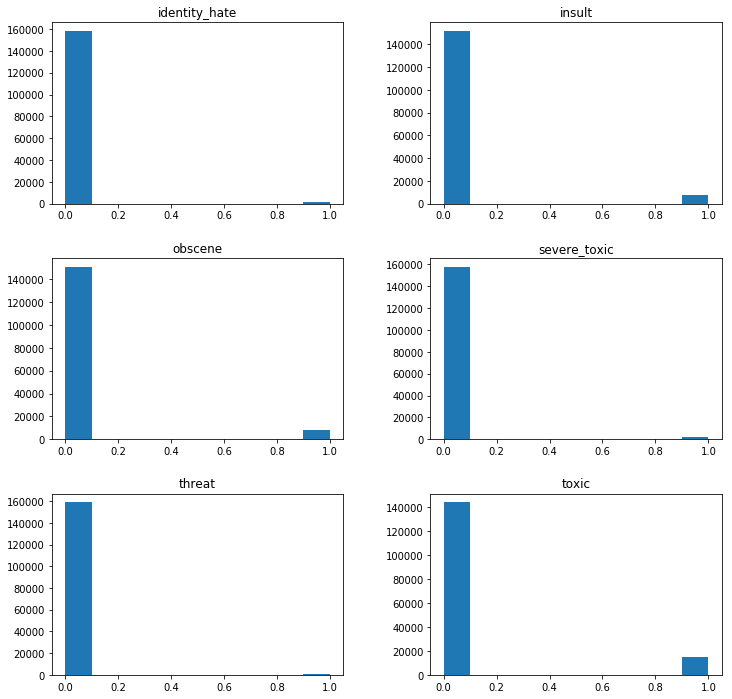

In [44]:
train.hist(grid=False, figsize=(12,12), column=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

## Baseline classifiers

### Logistic regression

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

submission = pd.DataFrame.from_dict({'id': test['id']})
scores = []
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    submission[class_name] = classifier.predict_proba(test_word_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission_logreg.csv', index=False)

CV score for class toxic is 0.9571333055320128
CV score for class severe_toxic is 0.9848179311278528
CV score for class obscene is 0.9799025526624684
CV score for class threat is 0.9772005330620867
CV score for class insult is 0.9694678609681838
CV score for class identity_hate is 0.9672950245284176
Total CV score is 0.9726362013135037


#### Below we show an example of batching on a tiny dataset. Checkout tiny_data.csv

In [67]:
reload(data_utils)
data_loader = data_utils.DataLoader(path="./data")
tiny_data = data_loader.readTinyData(verbose=True)
bg = data_loader.batchGenerator(tiny_data, batch_size=2, num_epochs=3, verbose=True)

for i, (batch_comments, batch_labels) in enumerate(bg):
    print("\nBatch {0}\n----------".format(i+1))
    for c,l in zip(batch_comments, batch_labels):
        print(c,l)

Loaded tiny_data.csv: Num rows = 8, Num cols = 8
Column names: ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']

Batch 1
----------
b'This is severe_toxic comment' [1 1 0 0 0 0]
b'This is toxic comment' [1 0 0 0 0 0]

Batch 2
----------
b'This is ok comment' [0 0 0 0 0 0]
b'This is obscene comment' [1 0 1 0 0 0]

Batch 3
----------
b'This is threat comment' [0 1 0 1 0 0]
b'This is hate comment' [0 0 0 0 1 1]

Batch 4
----------
b'This is really bad comment' [1 1 1 1 1 1]
b'This is insult comment' [0 0 0 0 1 0]
*************Epoch 1 finished*************


Batch 5
----------
b'This is obscene comment' [1 0 1 0 0 0]
b'This is threat comment' [0 1 0 1 0 0]

Batch 6
----------
b'This is hate comment' [0 0 0 0 1 1]
b'This is severe_toxic comment' [1 1 0 0 0 0]

Batch 7
----------
b'This is ok comment' [0 0 0 0 0 0]
b'This is insult comment' [0 0 0 0 1 0]

Batch 8
----------
b'This is toxic comment' [1 0 0 0 0 0]
b'This is really bad comment' [1 1 1 1 